In [3]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [4]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using LuxDeviceUtils: cpu_device, gpu_device
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

Precompiling PhasorNetworks
  ✓ PhasorNetworks
  1 dependency successfully precompiled in 10 seconds. 424 already precompiled.


In [5]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [6]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [7]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [8]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [9]:
function build_mlp(args)
    phasor_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), x -> x, PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

function build_spiking_mlp(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), MakeSpiking(spk_args, repeats), PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_spiking_mlp (generic function with 1 method)

In [10]:
function build_mlp_f32(args)
    phasor_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), x -> x, PhasorDenseF32(2 => 128), PhasorDenseF32(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

function build_spiking_mlp_f32(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), MakeSpiking(spk_args, repeats), PhasorDenseF32(2 => 128), PhasorDenseF32(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_spiking_mlp_f32 (generic function with 1 method)

In [11]:
import .PhasorNetworks: v_bundle_project, neuron_constant, spike_current, bias_current, gaussian_kernel, is_active

In [12]:
args = Args()

Args(0.0003, 256, 10, false, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [13]:
train_loader, test_loader = getdata(args)
x, y = first(train_loader)

([0.4363590795046628 -0.020726939563912576 … -0.014802110970796872 -0.0019893102515646105; -0.17784306532747968 0.3038012525038328 … -0.07276908176492998 -0.005627426425963785], Bool[0 0 … 1 1; 1 1 … 0 0])

# Test ODE Layer

In [14]:
to_phase = Chain(LayerNorm((2,)), x -> tanh_fast.(x))
ps_phase, st_phase = Lux.setup(args.rng, to_phase)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple()), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [15]:
p0, _ = to_phase(x, ps_phase, st_phase)

([0.9711341735396107 -0.1628081753962095 … -0.1339564920906035 -0.07084449409788965; -0.7382633272485227 0.8960409235587877 … -0.39980853999123117 -0.08884499833474777], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

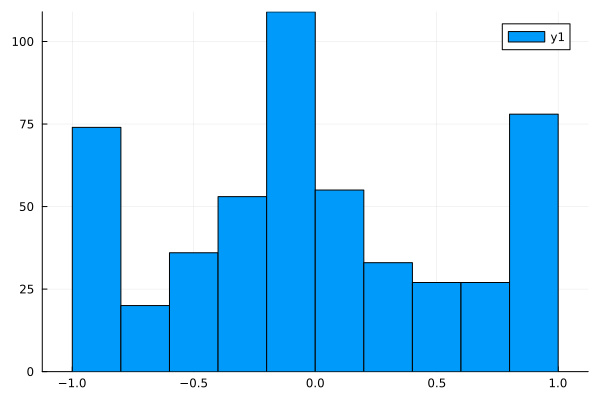

In [16]:
histogram(vec(p0))

In [17]:
stt_phase = st_phase
for (x, _) in train_loader
    _, stt_phase = to_phase(x, ps_phase, stt_phase)
end

In [18]:
ps_phase

(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple())

In [19]:
stt_phase

(layer_1 = NamedTuple(), layer_2 = NamedTuple())

In [20]:
using ChainRulesCore: ignore_derivatives

In [21]:
function phase_to_current(phases::AbstractArray; spk_args::SpikingArgs)
    function inner(t::Real)
        output = zero(phases)

        ignore_derivatives() do
            times = phases .* spk_args.t_period
            times = mod.(times, spk_args.t_period)

            #add currents into the active synapses
            current_kernel = x -> gaussian_kernel(x, t, spk_args.t_window)
            impulses = current_kernel(times)
            output .+= impulses
        end

        return output
    end

    return inner
end

phase_to_current (generic function with 1 method)

In [22]:
xfn = phase_to_current(x, spk_args=spk_args)

(::var"#inner#43"{SpikingArgs, LinearAlgebra.Adjoint{Float64, Matrix{Float64}}}) (generic function with 1 method)

In [23]:
xfn(0.4)

2×256 Matrix{Float64}:
 0.0367008     0.0          5.11018e-138  …  4.11898e-169  0.0           0.0
 3.19094e-194  8.96151e-11  0.0              0.0           1.56768e-302  0.0

In [24]:
solver_args

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [25]:
sol_model = Chain(LayerNorm((2,)), 
                    x -> tanh_fast.(x),
                    x -> phase_to_current(x, spk_args=spk_args),
                    PhasorODE(Chain(Dense(2 => 128)), tspan = (0.0, 10.0), dt = solver_args[:dt]))

Chain(
    layer_1 = LayerNorm((2,), affine=true, dims=Colon()),  # 4 parameters
    layer_2 = WrappedFunction(#46),
    layer_3 = WrappedFunction(#47),
    layer_4 = PhasorODE(
        model = Dense(2 => 128),        # 384 parameters
    ),
)         # Total: 388 parameters,
          #        plus 0 states.

In [26]:
ps_sol, st_sol = Lux.setup(args.rng, sol_model)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.03740502 0.007607913; 0.032051656 -0.14364149; … ; 0.17915592 -0.04504438; -0.20711923 0.07185902], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [27]:
y_sol, _ = sol_model(x, ps_sol, st_sol)

(ODESolution{ComplexF32, 3, Vector{Matrix{ComplexF32}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Matrix{ComplexF32}}}, ODEProblem{Matrix{ComplexF32}, Tuple{Float64, Float64}, false, @NamedTuple{weight::Matrix{Float32}, bias::Matrix{Float32}}, ODEFunction{false, SciMLBase.AutoSpecialize, Main.PhasorNetworks.var"#dudt#145"{PhasorODE{Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, SciMLSensitivity.InterpolatingAdjoint{0, true, Val{:central}, SciMLSensitivity.ZygoteVJP}, Tuple{Float64, Float64}}, var"#inner#43"{SpikingArgs, Matrix{Float64}}, @NamedTuple{}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(

In [28]:
solution_to_phase(y_sol, spk_args=spk_args)

128×256 Matrix{Float64}:
  0.998648    0.694301   -0.735815   0.826223  …   0.670665    0.852332
  0.59662    -0.17601    -0.509708  -0.177775     -0.871134   -0.187953
  0.460809   -0.224551   -0.44439   -0.176228     -0.742269   -0.172364
 -0.916049    0.71407    -0.861215   0.825628      0.58451     0.846346
 -0.376661    0.842768    0.479158   0.821588      0.101162    0.805651
  0.830389    0.574469   -0.611045   0.830168  …   0.863084    0.89145
  0.445323   -0.227905   -0.435236  -0.176124     -0.728614   -0.171322
 -0.0380102  -0.317648    0.300752  -0.173415     -0.289696   -0.144028
  0.401016   -0.236437   -0.405663  -0.175864     -0.690345   -0.168688
  0.70438    -0.0204142  -0.553996  -0.184588     -0.987914   -0.254601
  0.345858   -0.245582   -0.358852  -0.175586  …  -0.643846   -0.165885
  0.464982   -0.223606   -0.44677   -0.176257     -0.745978   -0.172658
  0.214735   -0.264751   -0.160589  -0.175008     -0.533706   -0.160057
  ⋮                                     

In [29]:
mean(abs.(solution_to_phase(sol_model(x, ps_sol, st_sol)[1], spk_args=spk_args)))

0.4811146624598816

In [30]:
psf_sol = ComponentArray(ps_sol)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.03740502 0.007607913; 0.032051656 -0.14364149; … ; 0.17915592 -0.04504438; -0.20711923 0.07185902], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]))

In [31]:
solution_to_potential(y_sol)

128×256×1 Array{ComplexF32, 3}:
[:, :, 1] =
   0.00021068+8.94792f-7im   …   0.000231303+0.000115728im
  0.000236426+0.000754822im     -0.000532208-0.000356707im
  -7.36044f-5+0.000594796im     -0.000705884-0.000424565im
  0.000508596-0.000137335im      0.000704899+0.000369417im
 -0.000446465-0.00109397im       0.000656897+0.00045967im
   0.00109756+0.000647284im  …   0.000530012+0.000188094im
  -6.26055f-5+0.000360876im     -0.000448061-0.000267501im
  -0.00112022-0.000134408im      -0.00109369-0.000531659im
  -2.00404f-5+6.23542f-5im       -8.75857f-5-5.1312f-5im
  0.000827098+0.00110607im       -0.00025002-0.000257355im
 -0.000203938+0.000387696im  …  -0.000632029-0.000362836im
 -0.000101836+0.000921935im      -0.00108062-0.000651314im
 -0.000845158+0.000675946im      -0.00164164-0.000902882im
             ⋮               ⋱              ⋮
  0.000566028-0.000738219im       0.00139935+0.000788985im
 -0.000922154-0.000370918im     -0.000626938-0.000269653im
 -0.000526547+0.000784685im 

In [32]:
withgradient(p -> mean(abs.(solution_to_phase(sol_model(x, p, st_sol)[1], spk_args=spk_args))), psf_sol)

(val = 0.4811146616143198, grad = ((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[0.0; 0.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[-0.0015978559 0.007856004; 0.0034180158 0.0007626842; … ; 0.00070424395 0.0028010043; 0.0010146722 0.0029245913], bias = Float32[-0.11123301; -0.00811493; … ; -0.013981292; -0.008197764;;])),))

In [33]:
ode_model = Chain(LayerNorm((2,)), 
                    x -> tanh_fast.(x),
                    x -> phase_to_current(x, spk_args=spk_args),
                    PhasorODE(Chain(Dense(2 => 128)), tspan = (0.0, 10.0), dt = solver_args[:dt]),
                    x -> solution_to_phase(x, spk_args=spk_args)[:,:,end],
                    PhasorDenseF32(128 => 2))

Chain(
    layer_1 = LayerNorm((2,), affine=true, dims=Colon()),  # 4 parameters
    layer_2 = WrappedFunction(#52),
    layer_3 = WrappedFunction(#53),
    layer_4 = PhasorODE(
        model = Dense(2 => 128),        # 384 parameters
    ),
    layer_5 = WrappedFunction(#54),
    layer_6 = PhasorDenseF32((128, 2)),  # 260 parameters
)         # Total: 648 parameters,
          #        plus 0 states.

In [34]:
ps_ode, st_ode = Lux.setup(args.rng, ode_model)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.15707646 -0.044632133; -0.06643613 -0.044867363; … ; -0.027456176 -0.1603537; 0.09821631 0.13010322], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = NamedTuple(), layer_6 = (weight = Float32[1.7387471 -1.7479336 … -0.45474225 -0.21259138; -0.49817917 -0.93274075 … -1.2375036 -0.14219837], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [35]:
y_ode, _ = ode_model(x, ps_ode, st_ode)

([-0.9036503487407623 0.7367738732688204 … 0.5649390440251838 0.7897498949514018; 0.882302318484595 0.504073180221312 … 0.7126329366524836 0.1276507768477951], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [36]:
y_ode

2×256 Matrix{Float64}:
 -0.90365   0.736774  -0.843348   0.800166   …  0.863415  0.564939  0.78975
  0.882302  0.504073  -0.660273  -0.0610325     0.881219  0.712633  0.127651

In [37]:
psf = ComponentArray(ps_ode)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.15707646 -0.044632133; -0.06643613 -0.044867363; … ; -0.027456176 -0.1603537; 0.09821631 0.13010322], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = Float32[], layer_6 = (weight = Float32[1.7387471 -1.7479336 … -0.45474225 -0.21259138; -0.49817917 -0.93274075 … -1.2375036 -0.14219837], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0]))

In [38]:
mean(quadrature_loss(ode_model(x, psf, st_ode)[1], y))

1.0147273778617116

In [39]:
withgradient(p -> mean(quadrature_loss(ode_model(x, p, st_ode)[1], y)), psf)

(val = 1.0147273955058975, grad = ((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[0.0; 0.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[-0.005804397 -0.020427847; -0.02016539 0.02985944; … ; 0.006713479 -0.0011495394; 0.0027645517 -0.0020869835], bias = Float32[2.3588047; 16.236038; … ; 6.095558; 0.8529597;;]), layer_5 = Float32[], layer_6 = (weight = Float32[2.54707f-5 -3.1529275f-5 … -0.00054059975 0.0003321721; 0.024530903 -0.027356243 … -0.028274508 0.027489852], bias_real = Float32[-0.007947453, -0.05606113], bias_imag = Float32[-0.00854424, -0.03838088])),))

In [48]:
losses, ps_train, st_train = train(ode_model, psf, st_ode, train_loader, args, verbose=true)

[ Info: Training on CPU


Epoch 1 loss: 1.0147273955058975
Epoch 1 loss: 1.1115025911862333
Epoch 1 loss: 1.0231060615503567
Epoch 1 loss: 0.9333091648160403
Epoch 1 loss: 0.8502143617858994
Epoch 1 loss: 0.8212507743890465
Epoch 1 loss: 0.7909864350219129
Epoch 1 loss: 0.6909265393374718
Epoch 1 loss: 0.7700958121536943
Epoch 1 loss: 0.7096752577496179
Epoch 1 loss: 0.7681041898850307
Epoch 1 loss: 0.6834330355636126
Epoch 1 loss: 0.7033086894525113
Epoch 1 loss: 0.6560739999417288
Epoch 1 loss: 0.6846499907957104
Epoch 1 loss: 0.6358375098767978
Epoch 1 loss: 0.6330536592109604
Epoch 1 loss: 0.5966288485083143
Epoch 1 loss: 0.6343573982397587
Epoch 1 loss: 0.5846164517930202
Epoch 1 loss: 0.5777448591542956
Epoch 1 loss: 0.5540416156750115
Epoch 1 loss: 0.5536432246308475
Epoch 1 loss: 0.5631456648529999
Epoch 1 loss: 0.5530410029414405
Epoch 1 loss: 0.560503102694336
Epoch 1 loss: 0.5658163688557829
Epoch 1 loss: 0.5492073927210518
Epoch 1 loss: 0.524551658045241
Epoch 1 loss: 0.5252654843717577
Epoch 1 loss

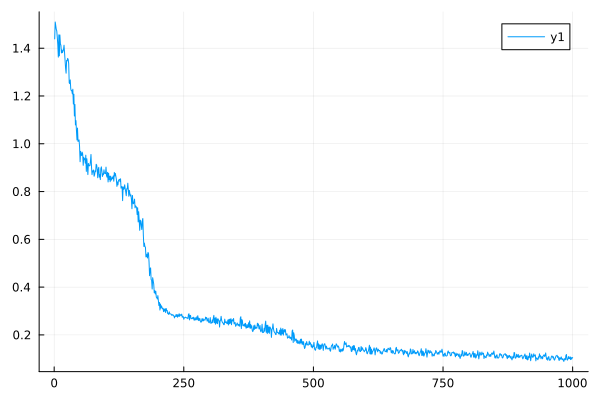

In [ ]:
plot(losses)

In [ ]:
loss_and_accuracy(test_loader, model, ps_train, st_train)

(0.09899020936212574, 0.952734375)